In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PP.jl")
include("Data_Generation_PP.jl")
include("Estimation_PP.jl")
include("Evaluation_PP.jl")
# # include("Plot_Figures.jl")
include("Implement_All_Methods_PP.jl")
include("Models_PP.jl")

Solve_RO (generic function with 1 method)

## Functions

In [2]:
function Generate_Input_this(S_train, N, N_u, K, offdiag_sign,max_offdiag,P_bar,is_original_setting)
    Input_Data_this = Dict()
    A_true, B_true = Generate_Coef(N_u, N, max_offdiag, offdiag_sign,is_original_setting);
    P_train,PM_train,choice_train,PM_train_extend = Generate_Data(N,S_train,A_true,B_true,P_bar);

    Input_Data_this["A_true"] = A_true;
    Input_Data_this["B_true"] = B_true;
    Input_Data_this["P_dag"] = round.(rand(N, K) .* P_bar; digits=2);
    Input_Data_this["P_train"] = P_train;
    Input_Data_this["PM_train_extend"] = PM_train_extend;
    Input_Data_this["choice_train"] = choice_train;

    A_hat,B_hat = Estimate_MNL_Para(PM_train_extend, P_train, choice_train,S_train, N);

    # A_hat,B_hat = Estimate_MNL_Para_Ridge(PM_train_extend, P_train, choice_train,S_train, N, 10.0);

    Input_Data_this["A_hat"] = A_hat
    Input_Data_this["B_hat"] = B_hat
    return Input_Data_this
end

Generate_Input_this (generic function with 1 method)

In [3]:
function Get_Input_Data(Input_Data_this)
    A_true = Input_Data_this["A_true"]
    B_true = Input_Data_this["B_true"]
    P_dag = Input_Data_this["P_dag"]
    P_train = Input_Data_this["P_train"]
    PM_train_extend = Input_Data_this["PM_train_extend"]
    choice_train = Input_Data_this["choice_train"]
    A_hat = Input_Data_this["A_hat"]
    B_hat = Input_Data_this["B_hat"]
    return A_true,B_true,P_dag,P_train,PM_train_extend,choice_train,A_hat,B_hat
end

Get_Input_Data (generic function with 1 method)

In [4]:
function solve_ETO_this(N,N_u,K,A,B,A_true, B_true,P_dag,Time_Limit)
    RST_this = Dict()
    status_this = "NotDefined"
    obj_,X_,Promo_, time_,status_ = Solve_ETO(N,N_u,K,A, B,P_dag,Time_Limit)
    if status_ != "OPTIMAL"
        status_this = status_
    else
        status_this = status_
        rev_, price_ = compute_oof(X_, A_true, B_true, vcat(Promo_,1), P_dag)
        RST_this["obj"] = obj_
        RST_this["price"] = price_
        RST_this["promo"] = Promo_
        RST_this["time"] = time_
        RST_this["Rev"] = rev_
        RST_this["status"] = status_
    end
    return RST_this,status_this
end

solve_ETO_this (generic function with 1 method)

In [5]:
function solve_RO_this(N,N_u,K,A_hat,B_hat,A_true, B_true,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma_list,dual_norm,Time_Limit)
    RST_this = Dict()
    status_this = "NotDefined"
    for gamma in gamma_list
        obj_RO,X_RO,Promo_RO, time_RO,status_RO = Solve_RO(N,N_u,K,A_hat,B_hat,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma * ones(N),dual_norm,Time_Limit)
        println("gamma=$(gamma),status:",status_RO,",time=$time_RO")
        if status_RO != "OPTIMAL"
            status_this = status_RO
            break
        else
            status_this = status_RO
            rev_RO, price_RO = compute_oof(X_RO, A_true, B_true, vcat(Promo_RO,1), P_dag)
            RST_this["obj_gamma=$(gamma)"] = obj_RO
            RST_this["price_gamma=$(gamma)"] = price_RO
            RST_this["promo_gamma=$(gamma)"] = Promo_RO
            RST_this["time_gamma=$(gamma)"] = time_RO
            RST_this["Rev_gamma=$(gamma)"] = rev_RO
            RST_this["status"] = status_this
        end
    end
    return RST_this,status_this
end

solve_RO_this (generic function with 1 method)

#### Parameters

In [6]:
Params = get_default_params_PP()
seed = Params["seed"]
N = Params["N"]
N_u = Params["N_u"] 
K = Params["K"] 
S_train = Params["S_train"]
S_test = Params["S_test"]
P_bar = Params["P_bar"]
iterations = Params["iterations"]
offdiag_sign = Params["offdiag_sign"]
max_offdiag = Params["max_offdiag"]
Time_Limit = Params["Time_Limit"]
gamma_list = Params["gamma_list"]
dual_norm = Params["dual_norm"]
psi_lb = Params["psi_lb"]
psi_ub = Params["psi_ub"]
phi_lb = Params["phi_lb"]
phi_ub = Params["phi_ub"]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [7]:
is_original_setting = true
Random.seed!(seed)

project_dir = "Joint_Pricing_and_Promotion/"
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/")
if !isdir(data_dir)
    mkpath(data_dir)
end
if is_original_setting
    sub_file_name = "MS_2024_N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_Seed=$seed/"
else
    sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"
end
this_data_file = string(data_dir,project_dir,sub_file_name)
if !isdir(this_data_file)
    mkpath(this_data_file)
end
println(this_data_file)
save(string(this_data_file, "Params.jld2"), Params);

/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion/MS_2024_N=3_N_u=1_K=30_S_train=100_Seed=3/


In [8]:
Result_All = Dict()
iter = 1
while iter <= iterations
    t_start = time()  # 记录开始时间
    Input_Data_this = Generate_Input_this(S_train, N, N_u, K, offdiag_sign,max_offdiag,P_bar,is_original_setting)
    A_true,B_true,P_dag,P_train,PM_train_extend,choice_train,A_hat,B_hat = Get_Input_Data(Input_Data_this)
    if any(isnan, A_hat) || any(isnan, B_hat) || norm([vec(A_true .- A_hat);vec(B_true .- B_hat)],2) >= 10
        println("Estimate contains NaN values")
        continue
    end
    Result_All["Input_Data_iter=$(iter)"] = Input_Data_this

    RST_Oracle,status_Oracle = solve_ETO_this(N,N_u,K,A_true,B_true,A_true, B_true,P_dag,Time_Limit)
    println("Oracle: status = ",status_Oracle,",time=",RST_Oracle["time"])
    if status_Oracle != "OPTIMAL"
        println("Oracle did not approach the optimal solution")
        continue
    end
    Result_All["RST_Oracle_iter=$(iter)"] = RST_Oracle

    RST_ETO,status_ETO = solve_ETO_this(N,N_u,K,A_hat,B_hat,A_true, B_true,P_dag,Time_Limit)
    println("ETO: status = ",status_ETO,",time=",RST_ETO["time"])
    if status_ETO != "OPTIMAL"
        println("ETO did not approach the optimal solution")
        continue
    end
    Result_All["RST_ETO_iter=$(iter)"] = RST_ETO
    
    obj_RO,X_RO,Promo_RO, time_RO,status_RO = Solve_RO(N,N_u,K,A_hat,B_hat,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,0.0 * ones(N),dual_norm,Time_Limit)
    if status_RO != "OPTIMAL"
        println("RO did not approach the optimal solution")
        continue
    end
    rev_RO, price_RO = compute_oof(X_RO, A_true, B_true, vcat(Promo_RO,1), P_dag)
    if abs(rev_RO - RST_ETO["Rev"]) >= 0.001
        println("ETO rev is not equivalent to RO rev")
        continue
    end

    RST_RO,status_RO = solve_RO_this(N,N_u,K,A_hat,B_hat,A_true, B_true,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma_list,dual_norm,Time_Limit)
    # println("RO status = ",status_RO)
    if status_RO != "OPTIMAL"
        println("RO did not approach the optimal solution")
        continue
    end
    Result_All["RST_RO_iter=$(iter)"] = RST_RO
    save(string(this_data_file, "Result_All.jld2"), Result_All);
    t_end = time()  # 记录结束时间
    println("******* Time for iter $iter: ", round(t_end - t_start, digits=2), " seconds *********")
    iter = iter + 1
end
save(string(this_data_file, "Result_All.jld2"), Result_All);

Oracle: status = OPTIMAL,time=2.4592630863189697
ETO: status = OPTIMAL,time=8.172795057296753
ETO rev is not equivalent to RO rev
Oracle: status = OPTIMAL,time=1.6556050777435303
ETO: status = OPTIMAL,time=11.268110990524292
gamma=0.0,status:OPTIMAL,time=17.70019817352295
gamma=0.005,status:OPTIMAL,time=19.95078206062317
gamma=0.01,status:OPTIMAL,time=19.55728507041931
gamma=0.015,status:OPTIMAL,time=20.18238115310669
gamma=0.02,status:OPTIMAL,time=22.364686012268066
gamma=0.03,status:OPTIMAL,time=24.576303958892822
gamma=0.04,status:OPTIMAL,time=27.746755838394165
gamma=0.06,status:OPTIMAL,time=60.24756407737732
gamma=0.08,status:OPTIMAL,time=51.59404993057251
******* Time for iter 1: 295.97 seconds *********
Oracle: status = OPTIMAL,time=2.166210889816284
ETO: status = OPTIMAL,time=15.09918999671936
gamma=0.0,status:OPTIMAL,time=35.290026903152466
gamma=0.005,status:OPTIMAL,time=45.45727801322937
gamma=0.01,status:OPTIMAL,time=36.301584005355835
gamma=0.015,status:OPTIMAL,time=33.992

In [9]:
Rev_Oracle = [Result_All["RST_Oracle_iter=$(iter)"]["Rev"] for iter in 1:iterations]
Rev_ETO = [Result_All["RST_ETO_iter=$(iter)"]["Rev"] for iter in 1:iterations]
Rev_RO = zeros(iterations,length(gamma_list))
for iter in 1:iterations
    RST_RO = Result_All["RST_RO_iter=$(iter)"]
    for g_index in 1:length(gamma_list)
        gamma = gamma_list[g_index]
        Rev_RO[iter,g_index] = RST_RO["Rev_gamma=$(gamma)"]
    end
end
println("Rev_ETO/Rev_Oracle = ",round.(Rev_ETO./Rev_Oracle,digits=4))
println("Rev_RO/Rev_Oracle = ",round.(Rev_RO[:,1]./Rev_Oracle,digits=4))
println("Rev_ETO/Rev_Oracle = ",mean(Rev_ETO)/mean(Rev_Oracle))

Rev_ETO/Rev_Oracle = [0.497, 0.9904, 0.9138, 0.9425, 0.9829, 0.9899, 0.9559, 0.9438, 0.9851, 0.9864, 0.6313, 0.9903, 0.4496, 0.9885, 0.8546, 0.9603, 0.9451, 0.9221, 0.82, 0.9438, 0.9821, 0.9227, 0.9898, 0.5523, 0.6433, 0.8832, 0.9538, 0.9468, 0.9592, 0.778, 0.9841, 0.9569, 0.6148, 0.9319, 0.6444, 0.9134, 0.8557, 0.6319, 0.9613, 0.8592, 0.9557, 0.973, 0.9429, 0.8563, 0.981, 0.9646, 0.6898, 0.495, 0.9682, 0.9667, 0.689, 0.4508, 0.9359, 0.9529, 0.8808, 0.6051, 0.949, 0.6949, 0.938, 0.9828, 0.6613, 0.7973, 0.9645, 0.446, 0.7591, 0.9546, 0.6267, 0.9554, 0.9003, 0.6479, 0.785, 0.9556, 0.9285, 0.926, 0.7469, 0.6266, 0.926, 0.9577, 0.6338, 0.6317, 0.8894, 0.714, 0.945, 0.9904, 0.9702, 0.9637, 0.69, 0.8325, 0.8109, 0.8829, 0.5026, 0.5539, 0.7027, 0.5986, 0.9694, 0.7103, 0.5467, 0.9864, 0.6608, 0.8287]
Rev_RO/Rev_Oracle = [0.497, 0.9904, 0.9138, 0.9425, 0.9829, 0.9899, 0.9559, 0.9438, 0.9851, 0.9864, 0.6313, 0.9903, 0.4496, 0.9885, 0.8546, 0.9603, 0.9451, 0.9221, 0.82, 0.9438, 0.9821, 0.9227, 0.

In [10]:
RO_ETO_Ratio_Mean = zeros(length(gamma_list))
RO_ETO_Ratio_Std = zeros(length(gamma_list))
for g_index in 1:length(gamma_list)
    gamma = gamma_list[g_index]
    RO_ETO_Ratio_Mean[g_index] = mean(Rev_RO[:,g_index])/mean(Rev_ETO)
    RO_ETO_Ratio_Std[g_index] = std(Rev_RO[:,g_index])/std(Rev_ETO)
    println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
end

gamma=0.0,Mean =1.0000008069930493, Std =1.0000031235350144
gamma=0.005,Mean =1.0138071009989174, Std =0.9556215461788824
gamma=0.01,Mean =1.0319027221672825, Std =0.8688326134412954
gamma=0.015,Mean =1.0316683383707332, Std =0.8477502944782594
gamma=0.02,Mean =1.0238361633237454, Std =0.8294691663683239
gamma=0.03,Mean =1.0023760197251896, Std =0.7829508011201245
gamma=0.04,Mean =0.9695134604308954, Std =0.7554204278981517
gamma=0.06,Mean =0.8836080570842116, Std =0.7122548213230958
gamma=0.08,Mean =0.7937039967151646, Std =0.677196725365149


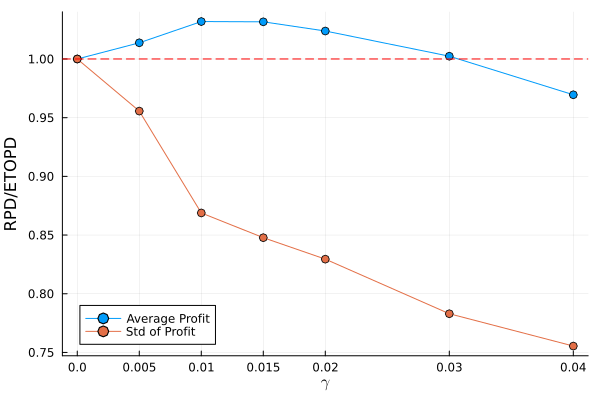

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion/MS_2024_N=3_N_u=1_K=30_S_train=100_Seed=3/RPP_vs_ETOPP.pdf"

In [15]:
end_index = length(gamma_list) - 2
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
display(current())
savefig(string(this_data_file, "RPP_vs_ETOPP.pdf"))

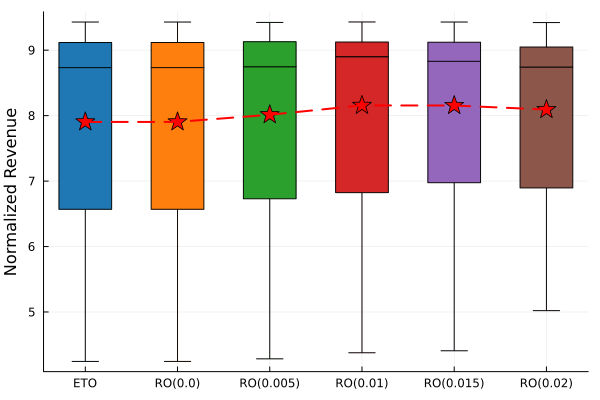

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/RPP_vs_ETOPP_BoxPlot.pdf"

In [21]:
chosen_indices = [1,2,3,4,5]
gamma_chosen = gamma_list[chosen_indices]
data = [Rev_ETO, [Rev_RO[:,ind] for ind in chosen_indices]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# --- 1) 展开成长表 ---
df = DataFrame(
    value = vcat(data...),
    group = repeat(labels, inner = length(data[1]))
)

mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

# --- 3) 绘制箱线图 ---
@df df boxplot(:group, :value;
    group = :group,
    palette = mycolors,
    legend = false,
    ylabel = "Normalized Revenue",
    # title = "Revenue Distribution"
)

# --- 4) 计算均值 ---
means = combine(groupby(df, :group), :value => mean => :mean_val)

for i in 1:length(labels)
    scatter!([labels[i]], [means.mean_val[i]];
        color = :red,
        marker = (:star, 10),
        label = "")
end

# # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
plot!(labels, means.mean_val;
    seriestype = :line,
    color = :red,
    lw = 2,
    ls = :dash,
    label = "Mean trend"
)
display(current())
savefig(string(data_dir, "RPP_vs_ETOPP_BoxPlot.pdf"))

In [12]:
# bad_idx = findall(i -> abs(Rev_ETO[i] - Rev_RO[i,1]) > 0.01, 1:length(Rev_ETO));
# keep_idx = setdiff(1:length(Rev_ETO), bad_idx);
# Rev_ETO_clean = Rev_ETO[keep_idx];
# Rev_Oracle_clean = Rev_Oracle[keep_idx];
# Rev_RO_clean = Rev_RO[keep_idx, :];
# RO_ETO_Ratio_Mean = zeros(length(gamma_list))
# RO_ETO_Ratio_Std = zeros(length(gamma_list))
# for g_index in 1:length(gamma_list)
#     gamma = gamma_list[g_index]
#     RO_ETO_Ratio_Mean[g_index] = mean(Rev_RO_clean[:,g_index])/mean(Rev_ETO_clean)
#     RO_ETO_Ratio_Std[g_index] = std(Rev_RO_clean[:,g_index])/std(Rev_ETO_clean)
#     println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
# end
# println("Rev_ETO/Rev_Oracle = ",mean(Rev_ETO_clean)/mean(Rev_Oracle_clean))

In [13]:
# end_index = length(gamma_list) -1
# plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
# plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
# hline!([1.0], linestyle=:dash, color=:red, label="")
# display(current())
# savefig(string(this_data_file, "RPP_vs_ETOPP_Clean.pdf"))